# Nachbildung Mathematischer Operationen durch ML-Modelle

## 1. Erstellung der Datensätze

## 1.1 Trainingsdaten

In [4]:
# import numpy as np
# import pandas as pd

# N = 100000

# x1 = np.random.uniform(-10, 10, N)
# x2 = np.random.uniform(-10, 10, N)

# y = x1 + x2   # oder x1 * x2, x1 - x2

# data = pd.DataFrame({
#     "x1": x1,
#     "x2": x2,
#     "y": y
# })

# data.to_csv("addition_dataset.csv", index=False)


## 1.2 Generalisierungsdatensätze

In [5]:
# import numpy as np
# import pandas as pd

# N_gen = 100_000

# # Neuer Wertebereich (nicht im Training enthalten)
# x1_gen = np.random.uniform(10, 20, N_gen)
# x2_gen = np.random.uniform(10, 20, N_gen)

# y_gen = x1_gen * x2_gen   # oder * , -

# generalization_data = pd.DataFrame({
#     "x1": x1_gen,
#     "x2": x2_gen,
#     "y": y_gen
# })

# generalization_data.to_csv("multiplication_gen_dataset.csv", index=False)

# 2. SVM 

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

#Setup for evlatuation

results = pd.DataFrame(columns=[
    "model",
    "operator",
    "dataset_type",
    "mse",
    "mae",
    "relative_error"
])

def log_results(results_df, model_name, operator, dataset_type, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    relative_error = np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + 1e-8))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    rmse = np.sqrt(mse)
    

    print(f"Results for {model_name} on {dataset_type} dataset ({operator}):")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Relative Error: {relative_error}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    new_row = {
        "model": model_name,
        "operator": operator,
        "dataset_type": dataset_type,
        "mse": mse,
        "mae": mae,
        "relative_error": relative_error,
        "mape": mape,
        "rmse": rmse
    }

    return pd.concat(
        [results_df, pd.DataFrame([new_row])],
        ignore_index=True
    )



## 2.1 Addition

In [2]:


# Load the dataset
data = pd.read_csv("addition_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svr_lin = SVR(kernel="linear", C=10, epsilon=0.01)
svr_lin.fit(X_train, y_train)

# Make predictions on Test set
y_pred = svr_lin.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

results = log_results(results, "SVR-linear", "addition", "test", y_test, y_pred)

print("C:", svr_lin.C)
print("Epsilon:", svr_lin.epsilon)
print("Kernel:", svr_lin.kernel)
print("Gamma:", svr_lin.gamma if hasattr(svr_lin, "gamma") else None)



Results for SVR-linear on test dataset (addition):
Mean Squared Error (MSE): 1.732199741685354e-05
Mean Absolute Error (MAE): 0.0034251641630859268
Mean Relative Error: 0.0013018782870338798
Mean Absolute Percentage Error (MAPE): 0.13018828254228837%
Root Mean Squared Error (RMSE): 0.004161970376739068
C: 10
Epsilon: 0.01
Kernel: linear
Gamma: scale


/var/folders/rh/7db0_9255q14q438w26k_f740000gn/T/ipykernel_34913/784134760.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(


In [3]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = svr_lin.predict(X_gen)

results = log_results(results, "SVR-linear", "addition", "generalization", y_gen, y_pred_gen)



Results for SVR-linear on generalization dataset (addition):
Mean Squared Error (MSE): 0.0002316643379129757
Mean Absolute Error (MAE): 0.015077112426105984
Mean Relative Error: 0.000502901313686782
Mean Absolute Percentage Error (MAPE): 0.0502901313686782%
Root Mean Squared Error (RMSE): 0.015220523575520511


## 2.2 Multiplikation - rbf-Kernel

In [4]:

# Load the dataset
data = pd.read_csv("multiplication_dataset.csv")

data = data.sample(n=20000, random_state=42)


X = data[["x1", "x2"]].values
y = data["y"].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svr_rbf = SVR(kernel="rbf", C=10, gamma="scale", epsilon=0.01)
svr_rbf.fit(X_train, y_train)

# Make predictions on Test set
y_pred = svr_rbf.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Relative Error: {relative_error}")

print("C:", svr_rbf.C)
print("Epsilon:", svr_rbf.epsilon)
print("Kernel:", svr_rbf.kernel)
print("Gamma:", svr_rbf.gamma if hasattr(svr_rbf, "gamma") else None)

results = log_results(results, "SVR-rbf", "multiplication", "test", y_test, y_pred)

Mean Squared Error: 0.030964836792467337
Mean Absolute Error: 0.04658233828763949
Mean Relative Error: 0.0021908643269368507
C: 10
Epsilon: 0.01
Kernel: rbf
Gamma: scale
Results for SVR-rbf on test dataset (multiplication):
Mean Squared Error (MSE): 0.030964836792467337
Mean Absolute Error (MAE): 0.04658233828763949
Mean Relative Error: 0.0021908643269368507
Mean Absolute Percentage Error (MAPE): 0.2190866642784091%
Root Mean Squared Error (RMSE): 0.17596828348446017


In [5]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = svr_rbf.predict(X_gen)

results = log_results(results, "SVR-rbf", "multiplication", "generalization", y_gen, y_pred_gen)


Results for SVR-rbf on generalization dataset (multiplication):
Mean Squared Error (MSE): 29867.831133586045
Mean Absolute Error (MAE): 148.78921438229798
Mean Relative Error: 0.6016759090905601
Mean Absolute Percentage Error (MAPE): 60.16759090905601%
Root Mean Squared Error (RMSE): 172.8231209462034


# 3. Entscheidungsbäume & Random Forests

## 3.1 Addition Entscheidungsbäume

In [6]:


# CSV laden
data = pd.read_csv("addition_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entscheidungsbaum (Regression)
tree_addition = DecisionTreeRegressor(
    max_depth=5,          # Begrenzung gegen Overfitting
    random_state=42
)

# Training
tree_addition.fit(X_train, y_train)

# Vorhersage
y_pred = tree_addition.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)


print(f"R²: {r2:.4f}")

results = log_results(results, "tree", "addition", "test", y_test, y_pred)


R²: 0.9617
Results for tree on test dataset (addition):
Mean Squared Error (MSE): 2.5472653238507763
Mean Absolute Error (MAE): 1.3356850223180594
Mean Relative Error: 1.7176408068193347
Mean Absolute Percentage Error (MAPE): 171.76530007609625%
Root Mean Squared Error (RMSE): 1.5960154522593997


In [7]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = tree_addition.predict(X_gen)

results = log_results(results, "tree", "addition", "generalization", y_gen, y_pred_gen)

Results for tree on generalization dataset (addition):
Mean Squared Error (MSE): 203.96011757899802
Mean Absolute Error (MAE): 13.684837926731722
Mean Relative Error: 0.445905514514502
Mean Absolute Percentage Error (MAPE): 44.5905514514502%
Root Mean Squared Error (RMSE): 14.281460624844996


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## 3.2 Entscheidungsbaum - Multiplikation

In [8]:

# CSV laden
data = pd.read_csv("multiplication_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entscheidungsbaum (Regression)
tree_multi = DecisionTreeRegressor(
    max_depth=5,          # Begrenzung gegen Overfitting
    random_state=42
)

# Training
tree_multi.fit(X_train, y_train)

# Vorhersage
y_pred = tree_multi.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)


print(f"R²: {r2:.4f}")

results = log_results(results, "tree", "multiplication", "test", y_test, y_pred)


R²: 0.7466
Results for tree on test dataset (multiplication):
Mean Squared Error (MSE): 280.94728577859456
Mean Absolute Error (MAE): 13.00443039944547
Mean Relative Error: 5.905916185772301
Mean Absolute Percentage Error (MAPE): 590.5921738405483%
Root Mean Squared Error (RMSE): 16.761482207089998


In [9]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = tree_multi.predict(X_gen)

results = log_results(results, "tree", "multiplication", "generalization", y_gen, y_pred_gen)

Results for tree on generalization dataset (multiplication):
Mean Squared Error (MSE): 25589.969818636073
Mean Absolute Error (MAE): 147.543470524564
Mean Relative Error: 0.6287013362062763
Mean Absolute Percentage Error (MAPE): 62.870133620627634%
Root Mean Squared Error (RMSE): 159.96865261242925


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## 3.3 Random Forest - Additon

In [10]:
# CSV laden
data = pd.read_csv("addition_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest mit Bagging
forest_add = RandomForestRegressor(
    n_estimators=200,      # Anzahl Bäume
    max_depth=10,          # Begrenzung der Baumtiefe
    bootstrap=True,        # Bagging (Standard, hier explizit)
    random_state=42,
    n_jobs=-1
)

# Training
forest_add.fit(X_train, y_train)

# Vorhersage
y_pred = forest_add.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)

print(f"R²: {r2:.4f}")

results = log_results(results, "forest", "addition", "test", y_test, y_pred)


R²: 0.9999
Results for forest on test dataset (addition):
Mean Squared Error (MSE): 0.00900843232429587
Mean Absolute Error (MAE): 0.07167191405536459
Mean Relative Error: 0.09854638980988975
Mean Absolute Percentage Error (MAPE): 9.854731327369661%
Root Mean Squared Error (RMSE): 0.09491276165140212


In [11]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = forest_add.predict(X_gen)

results = log_results(results, "forest", "addition", "generalization", y_gen, y_pred_gen)

Results for forest on generalization dataset (addition):
Mean Squared Error (MSE): 127.32664779438932
Mean Absolute Error (MAE): 10.518617746467749
Mean Relative Error: 0.3382421973638123
Mean Absolute Percentage Error (MAPE): 33.82421973638123%
Root Mean Squared Error (RMSE): 11.283911014997829


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 3.4 Random Forest - Multiplikation

In [12]:
# CSV laden
data = pd.read_csv("multiplication_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest mit Bagging
forest_mul = RandomForestRegressor(
    n_estimators=200,      # Anzahl Bäume
    max_depth=10,          # Begrenzung der Baumtiefe
    bootstrap=True,        # Bagging (Standard, hier explizit)
    random_state=42,
    n_jobs=-1
)

# Training
forest_mul.fit(X_train, y_train)

# Vorhersage
y_pred = forest_mul.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Relative Error: {relative_error}")
print(f"R²: {r2:.4f}")

results = log_results(results, "forest", "multiplication", "test", y_test, y_pred)

Mean Squared Error: 4.211337741312613
Mean Absolute Error: 1.356066506751319
Mean Relative Error: 0.24003553792986318
R²: 0.9962
Results for forest on test dataset (multiplication):
Mean Squared Error (MSE): 4.211337741312613
Mean Absolute Error (MAE): 1.356066506751319
Mean Relative Error: 0.24003553792986318
Mean Absolute Percentage Error (MAPE): 24.00357508746504%
Root Mean Squared Error (RMSE): 2.0521544145879016


In [13]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = forest_mul.predict(X_gen)

results = log_results(results, "forest", "multiplication", "generalization", y_gen, y_pred_gen)

Results for forest on generalization dataset (multiplication):
Mean Squared Error (MSE): 21130.523655082903
Mean Absolute Error (MAE): 131.56606527094934
Mean Relative Error: 0.5518279650476396
Mean Absolute Percentage Error (MAPE): 55.182796504763964%
Root Mean Squared Error (RMSE): 145.36341924666914


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# 4. Neuronale Netze

## 4.1 NN - Addition

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Datensatz laden
data = pd.read_csv("addition_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neuronales Netz
model = Sequential([
    Dense(32, activation="relu", input_shape=(2,)),
    Dense(32, activation="relu"),
    Dense(1)  # Regressionsoutput
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

# Training
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    verbose=1
)

# Test-Vorhersage
y_pred = model.predict(X_test).flatten()

# Evaluation

results = log_results(results, "neural_network", "addition", "test", y_test, y_pred)

Epoch 1/50


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step - loss: 8.1207 
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0426
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.0056
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 0.0013
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 7.5699e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 5.5153e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 4.1522e-04
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 3.1797e-04
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 2.4360e-04
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 1.8454e-04
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 1.4035e-04
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 1.0475e-04
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 7.9200e-05
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - loss: 6.4507e-05

In [16]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = model.predict(X_gen).flatten()

results = log_results(results, "neural_network", "addition", "generalization", y_gen, y_pred_gen)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 195us/step
Results for neural_network on generalization dataset (addition):
Mean Squared Error (MSE): 0.19637910531486502
Mean Absolute Error (MAE): 0.3467970417237612
Mean Relative Error: 0.011052566004097411
Mean Absolute Percentage Error (MAPE): 1.105256600409741%
Root Mean Squared Error (RMSE): 0.4431468213976774


## 4.2 NN - Multiplikation

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Datensatz laden
data = pd.read_csv("multiplication_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Skalierung
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neuronales Netz
model_mul = Sequential([
    Dense(32, activation="relu", input_shape=(2,)),
    Dense(32, activation="relu"),
    Dense(1)  # Regressionsoutput
])

model_mul.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

# Training
model_mul.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=128,
    verbose=1
)

# Test-Vorhersage
y_pred = model_mul.predict(X_test).flatten()

# Evaluation
results = log_results(results, "neural_network", "multiplication", "test", y_test, y_pred)

Epoch 1/50


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - loss: 414.1621
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 15.8887
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 4.9426
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 1.8877
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.9341
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 0.5460
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.3583
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.2685
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.2222
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 0.1905
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.1712
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.1572
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 0.1493
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.1379
Epoch 15/50
625/625 ━━━━━━━━━━━━━━━━━

In [19]:
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = model_mul.predict(X_gen).flatten()

results = log_results(results, "neural_network", "multiplication", "generalization", y_gen, y_pred_gen)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 205us/step
Results for neural_network on generalization dataset (multiplication):
Mean Squared Error (MSE): 4539.478414735325
Mean Absolute Error (MAE): 57.81049925091615
Mean Relative Error: 0.23395512295737192
Mean Absolute Percentage Error (MAPE): 23.39551229573719%
Root Mean Squared Error (RMSE): 67.37565149766884


In [20]:
results

,model,operator,dataset_type,mse,mae,relative_error,mape,rmse
0,SVR-linear,addition,test,1.732200e-05,0.003425,0.001302,0.130188,0.004162
1,SVR-linear,addition,generalization,2.316643e-04,0.015077,0.000503,0.050290,0.015221
2,SVR-rbf,multiplication,test,3.096484e-02,0.046582,0.002191,0.219087,0.175968
3,SVR-rbf,multiplication,generalization,2.986783e+04,148.789214,0.601676,60.167591,172.823121
4,tree,addition,test,2.547265e+00,1.335685,1.717641,171.765300,1.596015
5,tree,addition,generalization,2.039601e+02,13.684838,0.445906,44.590551,14.281461
6,tree,multiplication,test,2.809473e+02,13.004430,5.905916,590.592174,16.761482
7,tree,multiplication,generalization,2.558997e+04,147.543471,0.628701,62.870134,159.968653
8,forest,addition,test,9.008432e-03,0.071672,0.098546,9.854731,0.094913
9,forest,addition,generalization,1.273266e+02,10.518618,0.338242,33.824220,11.283911


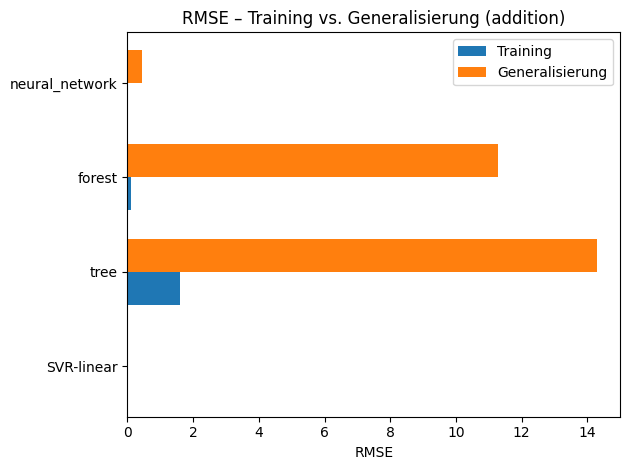

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Filter: Operator und Metrik
operator = "addition"
metric = "rmse"

subset = results[
    (results["operator"] == operator) &
    (results["dataset_type"].isin(["test", "generalization"]))
]

models = subset["model"].unique()
y_pos = np.arange(len(models))
bar_height = 0.35

train_values = []
gen_values = []

for model in models:
    train_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "test")
        ][metric].values[0]
    )
    gen_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "generalization")
        ][metric].values[0]
    )

plt.figure()
plt.barh(y_pos - bar_height/2, train_values, height=bar_height, label="Training")
plt.barh(y_pos + bar_height/2, gen_values, height=bar_height, label="Generalisierung")

plt.yticks(y_pos, models)
plt.xlabel(metric.upper())
plt.title(f"{metric.upper()} – Training vs. Generalisierung ({operator})")
plt.legend()
plt.tight_layout()
plt.show()
